In [1]:
!pip install seaborn
!pip install nltk
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
import os.path as path
from pyspark.sql import SparkSession
from pyspark.sql import column
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [4]:
def init_spark():
  return SparkSession \
        .builder \
        .appName("Big data project") \
        .config("spark.executor.memory", "16g") \
        .config("spark.driver.memory", "16g") \
        .getOrCreate()

spark = init_spark()

24/04/03 19:42:48 WARN Utils: Your hostname, DESKTOP-968IKC4 resolves to a loopback address: 127.0.1.1; using 172.31.102.226 instead (on interface eth0)
24/04/03 19:42:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/03 19:42:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
def get_data_dataframe(dir="final_dataset.csv"):
    # Specify the directory where the CSV files are saved
    csv_directory = dir
    
    # Read the CSV files back into a DataFrame
    final_df_read = spark.read.option("header", "true").option("multiline", "true").csv(csv_directory)
    
    # Add a random column to shuffle data randomly
    shuffled_df = final_df_read.withColumn("rand", rand())
    shuffled_df = shuffled_df.orderBy("rand")
    final_df_read = shuffled_df.drop("rand")
    return final_df_read



In [6]:
df=get_data_dataframe("final_dataset_all_imdb.csv").limit(20000)


In [7]:
df.columns

['movie_id',
 'movie_name',
 'genre',
 'description',
 'director',
 'actor1',
 'actor2',
 'actor3']

In [8]:
df.take(2)

[Row(movie_id='tt4519400', movie_name='Check Point', genre='action', description='Port City North Carolina: During a routine camp out, a local vagrant, a former marine discovers plans for an invasion in America. When he tries to notify the local Sheriff about his ...                See full summary\xa0»', director='Thomas J. Churchill', actor1='Kenny Johnson', actor2='Bill Goldberg', actor3='William Forsythe'),
 Row(movie_id='tt1417108', movie_name='Torrente 4', genre='action', description='The rude, lewd and crude Spanish ex-police officer Torrente finds himself facing jail time. Can he survive a twisted irony that places him where he has put so many others, both guilty and innocent?', director='Santiago Segura', actor1='Santiago Segura', actor2='Carlos Areces', actor3='Goyo Jiménez')]

In [9]:
# df.drop("director","actor2","actor3")

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stopword = set(stopwords.words('english'))

def preprocessing(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove specific characters #, @, and $
    text = re.sub(r'[#@\$]', '', text)
    
    # tokenize and convert to list
    tokens = word_tokenize(text)
    
    ## Lemmatize it 
    lemmatizer  = WordNetLemmatizer()
    
    ## lemmatize each token
   # text = [lemmatizer.lemmatize(token) for token in tokens]
    text = text.split()
    
    text = [word for word in text if word not in stopword]
    
    
    return " ".join(text) 

[nltk_data] Downloading package punkt to /home/umang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/umang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/umang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# pdd=df.toPandas()
# # pdd.drop_duplicates(inplace = True)
# # pdd.dropna( inplace = True )
# pdd.size

In [12]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,RandomForestClassificationModel

In [13]:
# df=combined_train_df

In [14]:
# df
# 

In [15]:
# Remove duplicate rows
df = df.dropDuplicates()

# Remove rows with null values
# df_no_null = df_no_duplicates.dropna()


In [16]:
df.count()

20000

In [17]:
# df=df_no_duplicates

In [18]:
# df = df.select([sum (col(c).isNull().cast("int")).alias(c) for c in df.columns])

# # Show the count of null values for each column
# df.show()


In [19]:
df = df.dropna()

In [20]:
# df = df.select([sum (col(c).isNull().cast("int")).alias(c) for c in df.columns])

# # Show the count of null values for each column
# df.show()
# Tokenization, stop word removal, and TF-IDF transformation for text data
director_indexer = StringIndexer(inputCol="director", outputCol="director_indexed")
actor1_indexer = StringIndexer(inputCol="actor1", outputCol="actor1_indexed")
actor2_indexer = StringIndexer(inputCol="actor2", outputCol="actor2_indexed")
actor3_indexer = StringIndexer(inputCol="actor3", outputCol="actor3_indexed")

tokenizer = RegexTokenizer(inputCol="description", outputCol="words", pattern="\\W")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="description_clean")

# Encoding genre labels
genre_indexer = StringIndexer(inputCol="genre", outputCol="label")

assembler = VectorAssembler(inputCols=["description_clean"], outputCol="features")


pipeline = Pipeline(stages=[director_indexer,actor1_indexer,actor2_indexer,actor3_indexer,tokenizer,remover,vectorizer, idf,genre_indexer,assembler])
transformed_df = pipeline.fit(df).transform(df)
# Combine the preprocessed text features with the genre labels
# combined_train_df = genre_indexer.fit(transformed_train_df).transform(transformed_train_df)


In [21]:
df=transformed_df

In [22]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Show the number of rows in each set
print("Training set count:", train_df.count())
print("Testing set count:", test_df.count())

24/04/03 19:43:02 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Training set count: 15339


24/04/03 19:43:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Testing set count: 3763


24/04/03 19:43:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


+---------+-----+
|    genre|count|
+---------+-----+
|adventure| 3088|
|    crime| 3155|
|   action| 2989|
|  romance| 3149|
|   horror| 2958|
+---------+-----+



24/04/03 19:43:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


       genre  count
0  adventure   3088
1      crime   3155
2     action   2989
3    romance   3149
4     horror   2958


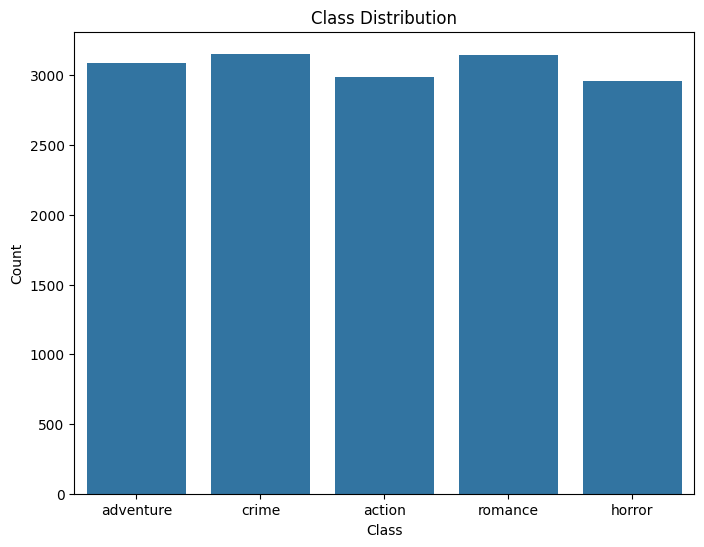

24/04/03 19:43:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


+---------+-----+
|    genre|count|
+---------+-----+
|adventure|  748|
|   action|  746|
|    crime|  760|
|  romance|  768|
|   horror|  741|
+---------+-----+



24/04/03 19:43:06 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


       genre  count
0  adventure    748
1     action    746
2      crime    760
3    romance    768
4     horror    741


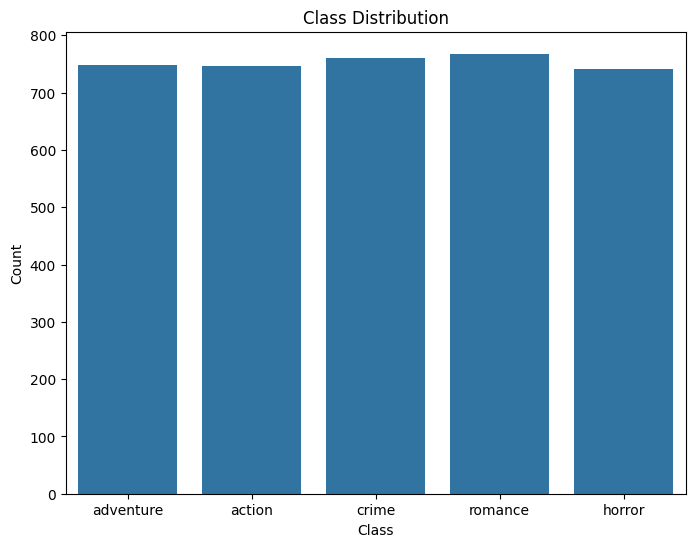

In [23]:
def print_class_distribution(df):
    # Group the DataFrame by the "genre" column and count the occurrences of each genre
    genre_counts = df.groupBy("genre").count()
    # Show the genre counts
    genre_counts.show()
    class_counts = genre_counts.toPandas()
    print(class_counts)
    plt.figure(figsize=(8, 6))
    sns.barplot(x="genre", y="count", data=class_counts)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
    

# def show_class_frequency_distribution(df):
#        # Plot class distribution
#     plt.figure(figsize=(8, 6))
#     sns.barplot(x="class", y="count", data=class_counts)
#     plt.title("Class Distribution")
#     plt.xlabel("Class")
#     plt.ylabel("Count")
#     plt.show()
#     plt.savefig(plots_dir + '/class_distribution.jpeg', dpi=300, bbox_inches='tight')
    #plt.show()
print_class_distribution(train_df)
print_class_distribution(test_df)

In [24]:
df

DataFrame[movie_id: string, movie_name: string, genre: string, description: string, director: string, actor1: string, actor2: string, actor3: string, director_indexed: double, actor1_indexed: double, actor2_indexed: double, actor3_indexed: double, words: array<string>, filtered_words: array<string>, raw_features: vector, description_clean: vector, label: double, features: vector]

In [25]:
# show_class_frequency_distribution("./

In [26]:
def print_and_return_mapping_of_index_to_label(df,predicting='genre'):
    # Collect distinct pairs of (label, genre)
    label_genre_mapping = df.select("label", predicting).distinct().collect()
    map={}
    # Print the mapping
    for mapping in label_genre_mapping:
        print("Label %s is mapped to genre '%s'" % (mapping.label, mapping.genre))
        map[mapping.label]= mapping.genre
    return map

In [27]:
mapping=print_and_return_mapping_of_index_to_label(df)

Label 3.0 is mapped to genre 'action'
Label 1.0 is mapped to genre 'crime'
Label 2.0 is mapped to genre 'adventure'
Label 4.0 is mapped to genre 'horror'
Label 0.0 is mapped to genre 'romance'


In [28]:
mapping

{3.0: 'action', 1.0: 'crime', 2.0: 'adventure', 4.0: 'horror', 0.0: 'romance'}

In [29]:
# Train the model
# model = pipeline.fit(train_df)
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features",maxBins=50000,)



# Make predictions
# predictions = model.transform(test_df)

In [31]:
# Train the Random Forest classifier large task binary with size 5.1 MiB
# 24/04/03 19:32:39 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
# 24/04/03 19:32:41 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
# 24/04/03 19:32:41 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
# 24/04/03 19:32:43 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
                                                                                

model = rf_classifier.fit(df)

24/04/03 19:43:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/04/03 19:43:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/04/03 19:43:30 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 50000 to 19102 (= number of training instances)
24/04/03 19:43:30 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/04/03 19:43:44 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/03 19:43:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/04/03 19:43:49 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/04/03 19:43:49 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/04/03 19:43:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


In [ ]:
# rfc_path = "models/rfc"

# rfc_model_path = "models/rfc_model"


In [ ]:
# rf_classifier.save(rfc_path)
# model.save(rfc_model_path)

In [ ]:
# model = RandomForestClassificationModel.load(rfc_model_path)

In [32]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [33]:
predictions = model.transform(test_df)

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/04/03 19:44:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


Accuracy: 0.36938612808929044


In [34]:
fi=model.featureImportances
print(fi)

(28334,[3,4,5,6,9,13,16,19,22,24,25,28,32,42,50,51,55,56,69,70,71,83,85,90,91,93,96,97,100,105,108,116,119,120,130,137,140,145,151,152,156,159,161,170,172,178,179,185,188,202,203,207,208,212,217,222,223,226,229,240,244,251,254,261,266,269,272,275,277,283,309,315,324,327,331,334,336,342,354,356,362,367,371,385,389,393,395,402,417,419,423,439,445,446,447,458,482,491,494,510,514,531,535,543,546,549,556,569,570,579,636,651,662,667,670,689,753,756,770,779,785,793,798,813,875,887,890,924,932,934,945,977,999,1006,1013,1022,1044,1045,1054,1074,1076,1083,1103,1120,1129,1209,1215,1216,1238,1258,1269,1278,1288,1299,1329,1354,1413,1433,1462,1469,1532,1564,1590,1597,1626,1707,1739,1746,1786,1809,1897,1907,1975,1979,1992,1999,2019,2027,2043,2099,2116,2145,2160,2273,2274,2471,2474,2746,2769,2784,2870,2872,2886,2911,2922,3011,3059,3104,3159,3195,3358,3379,3402,3479,3591,3630,3657,3739,3798,3909,3955,4111,4137,4254,4509,4762,4971,5073,5390,5428,5597,5607,5646,6178,6801,7575,8397,9265,9778,9824,10884,11

In [35]:
feature_columns = [col for col in df.columns if col != 'label'] 
for i, importance in enumerate(fi):
    print("Feature {}: {}".format(feature_columns[i],importance))

Feature movie_id: 0.0
Feature movie_name: 0.0
Feature genre: 0.0
Feature description: 0.0005339099385900136
Feature director: 0.004262499458541552
Feature actor1: 0.00046693855837182737
Feature actor2: 0.011466886199272008
Feature actor3: 0.0
Feature director_indexed: 0.0
Feature actor1_indexed: 0.021847757576897282
Feature actor2_indexed: 0.0
Feature actor3_indexed: 0.0
Feature words: 0.0
Feature filtered_words: 0.005754260178339847
Feature raw_features: 0.0
Feature description_clean: 0.0
Feature features: 0.011125677559953771


IndexError: list index out of range

In [38]:
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(feature_columns)), fi.toArray(), align='center')
# plt.yticks(range(len(feature_names)), feature_names)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importances')
# plt.show()

In [39]:
predictions.select("genre","label","prediction").head(30)

24/04/03 19:44:26 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


[Row(genre='adventure', label=2.0, prediction=0.0),
 Row(genre='action', label=3.0, prediction=0.0),
 Row(genre='action', label=3.0, prediction=4.0),
 Row(genre='crime', label=1.0, prediction=0.0),
 Row(genre='romance', label=0.0, prediction=0.0),
 Row(genre='romance', label=0.0, prediction=0.0),
 Row(genre='crime', label=1.0, prediction=0.0),
 Row(genre='romance', label=0.0, prediction=0.0),
 Row(genre='adventure', label=2.0, prediction=0.0),
 Row(genre='adventure', label=2.0, prediction=0.0),
 Row(genre='romance', label=0.0, prediction=0.0),
 Row(genre='romance', label=0.0, prediction=2.0),
 Row(genre='romance', label=0.0, prediction=0.0),
 Row(genre='adventure', label=2.0, prediction=0.0),
 Row(genre='horror', label=4.0, prediction=0.0),
 Row(genre='adventure', label=2.0, prediction=1.0),
 Row(genre='romance', label=0.0, prediction=1.0),
 Row(genre='adventure', label=2.0, prediction=2.0),
 Row(genre='adventure', label=2.0, prediction=0.0),
 Row(genre='crime', label=1.0, prediction=0

In [40]:


def print_statistis(predictions):

    # Compute raw scores on the test set
    predictionAndLabels = predictions.rdd.map(lambda lp: (lp.prediction, lp.label))
    
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = metrics.confusionMatrix().toArray()
    
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    total_predictions = confusion_matrix.sum(axis=1)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    
    # Statistics by class
    labels = predictions.rdd.map(lambda lp: lp.label).distinct().collect()
    accuracies = {}
    for label in sorted(labels):
        # print("______________________"+mapping[label]+"_____________________")
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
        
    
    # Calculate the accuracy for each label
    print(total_predictions)
    for label in range(len(total_predictions)):
        correct_predictions = confusion_matrix[label, label]
        accuracy = correct_predictions / total_predictions[label]
        accuracies[label] = accuracy
    
    # Print accuracies for each label
    for label, accuracy in accuracies.items():
        print("Accuracy for label %s: %s" % (label, accuracy))


In [41]:
print_statistis(predictions)


/home/umang/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/03 19:44:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/04/03 19:44:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/04/03 19:45:36 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


Summary Stats
Precision = 0.47106325706594887
Recall = 0.4605263157894737
F1 Score = 0.4657351962741184


Class 0.0 precision = 0.2876647834274953
Class 0.0 recall = 0.7955729166666666
Class 0.0 F1 Measure = 0.42254495159059474
Class 1.0 precision = 0.47106325706594887
Class 1.0 recall = 0.4605263157894737
Class 1.0 F1 Measure = 0.4657351962741184
Class 2.0 precision = 0.42704626334519574
Class 2.0 recall = 0.32085561497326204
Class 2.0 F1 Measure = 0.36641221374045807
Class 3.0 precision = 0.3469387755102041
Class 3.0 recall = 0.022788203753351208
Class 3.0 F1 Measure = 0.042767295597484274
Class 4.0 precision = 0.6035087719298246
Class 4.0 recall = 0.2321187584345479
Class 4.0 F1 Measure = 0.3352826510721248
[768. 760. 748. 746. 741.]
Accuracy for label 0: 0.7955729166666666
Accuracy for label 1: 0.4605263157894737
Accuracy for label 2: 0.32085561497326204
Accuracy for label 3: 0.022788203753351208
Accuracy for label 4: 0.2321187584345479


In [42]:
predictionAndLabels = predictions.rdd.map(lambda lp: (lp.prediction, lp.label))
    
    # Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()
# confusion_matrix_pd = confusion_matrix.toPandas()

# Create the confusion matrix plot using Seaborn


24/04/03 19:46:46 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/04/03 19:46:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


In [43]:
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=[mapping[i] for i in range(confusion_matrix.shape[0])], columns=[mapping[i] for i in range(confusion_matrix.shape[1])])


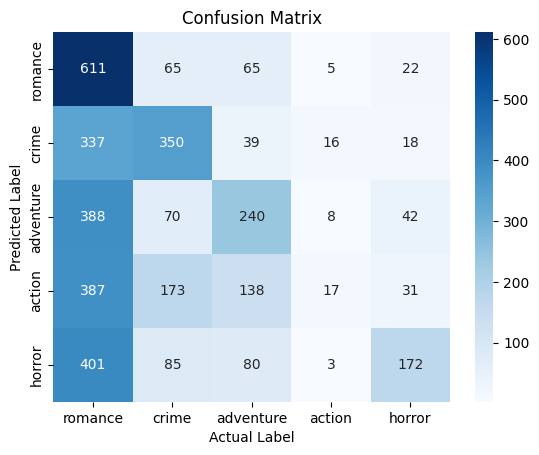

In [44]:
sns.heatmap(confusion_matrix_df, annot=True, fmt="g", cmap="Blues")

# Add labels and title
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix")

# Show plot
plt.show()

In [45]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/home/umang/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/03 19:47:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/04/03 19:47:59 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


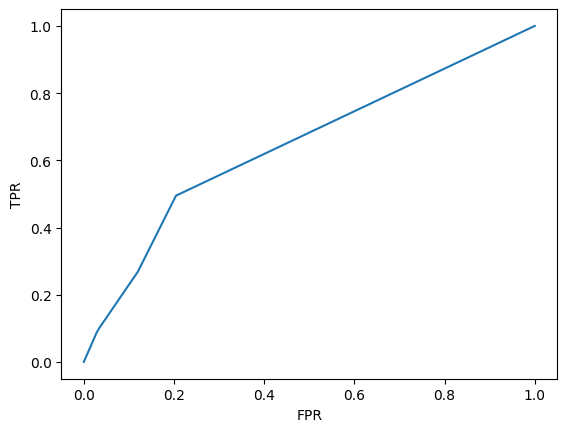

In [46]:

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
# plt.title(title)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x_val, y_val)